# Best Model

Python code for exercise #1 2) & 3).

In [249]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [250]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from IPython.display import Markdown

FIG_SIZE = (10, 5)

def _get_regressor(X, y, degree):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([("polybig_features", polybig_features), ("std_scaler", std_scaler), ("lin_reg",lin_reg)])
    polynomial_regression.fit(X, y)
    return polynomial_regression

def draw_plots(space, X, y):
    for style, width, degree in (("r-", 2, 1), ("b--", 2, 2), ("g-", 1, 3)):
        reg = _get_regressor(X, y, degree)

        # print(reg["lin_reg"].intercept_[0], reg["lin_reg"].coef_[0])

        y_newbig = reg.predict(space)

        label = f"{degree} degree{'s' if degree > 1 else ''}"
        plt.plot(space, y_newbig, style, label=label, linewidth=width)

def get_loss_df(X, y, Xval, yval, index=["MSE", "RMSE"]):
    df = pd.DataFrame(index=index)
    for degree in range(1, 4):
        prediction = _get_regressor(X, y, degree).predict(Xval)
        mse = mean_squared_error(yval, prediction)
        rmse = np.sqrt(mse)
        df[f"Degree {degree}"] = [mse, rmse]
    return df

# Task 2)

In [251]:
# Create the generated data

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1) 

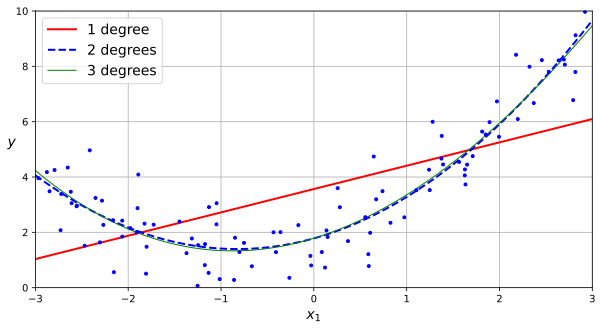

In [252]:
#| label: fig-gen-plot
#| fig-cap: "Polynomial regression models of different degrees on the generated data."

plt.figure(figsize=FIG_SIZE)

X_new = np.linspace(-3, 3, 100).reshape(100, 1)

draw_plots(X_new, X, y)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

In [253]:
#| label: tbl-gen-loss
#| tbl-cap: "Loss values for different polynomial degrees on the generated data."

df = get_loss_df(X,y, X, y)

Markdown(df.to_markdown())

|      |   Degree 1 |   Degree 2 |   Degree 3 |
|:-----|-----------:|-----------:|-----------:|
| MSE  |    3.02456 |   0.777194 |   0.772465 |
| RMSE |    1.73913 |   0.881586 |   0.8789   |

# Task 3)

In [254]:

# Download and prepare the *full* data
data_root = "https://github.com/ageron/data/raw/main/"
lifesat_full = pd.read_csv(data_root + "lifesat/lifesat_full.csv")
Xfull = lifesat_full[["GDP per capita (USD)"]].values
yfull = lifesat_full[["Life satisfaction"]].values

gdppc_col = "GDP per capita (USD)"
lifesat_col = "Life satisfaction"

min_life_sat = 4
max_life_sat = 9

min_gdp = 23_500
max_gdp = 62_500

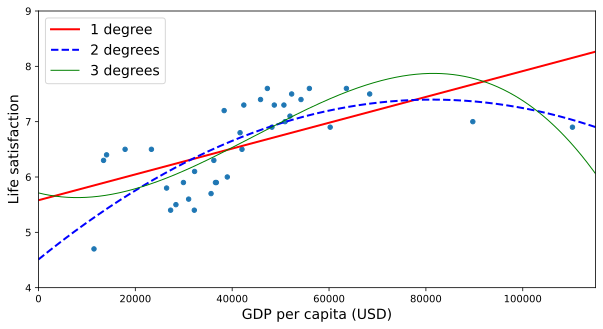

In [255]:
#| label: fig-gdp-full-plot
#| fig-cap: "Polynomial regression models of different degrees on the **full** GDP dataset."

lifesat_full.plot(kind='scatter', figsize=FIG_SIZE,
                        x=gdppc_col, y=lifesat_col, grid=True)

X_new = np.linspace(0, 115_000, 1000)
X_new = X_new[:, np.newaxis]
draw_plots(X_new, Xfull, yfull)

# plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.axis([0, 115_000, min_life_sat, max_life_sat])
plt.grid()
plt.show()

Now we come to the interesting part, where we actually compare the models using a validation set.

In [256]:
lifesat = pd.read_csv(data_root + "lifesat/lifesat.csv")
X = lifesat[["GDP per capita (USD)"]].values
y = lifesat[["Life satisfaction"]].values

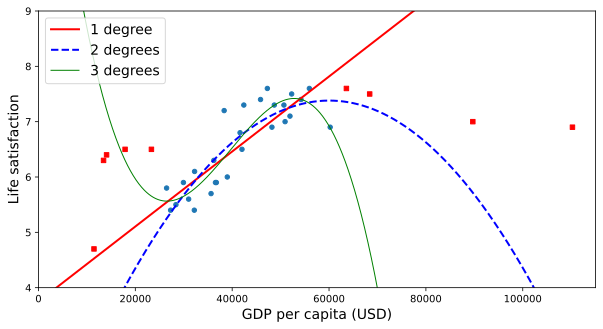

In [257]:
#| label: fig-gdp-sub-plot
#| fig-cap: "Polynomial regression models of different degrees trained only on a **subset** of the GDP dataset."

lifesat.plot(kind='scatter', x=gdppc_col, y=lifesat_col, figsize=FIG_SIZE)
missing_data = lifesat_full[(lifesat_full[gdppc_col] < min_gdp) |
                                  (lifesat_full[gdppc_col] > max_gdp)]
missing_data.plot(kind='scatter', x=gdppc_col, y=lifesat_col,
                  marker="s", color="r", grid=True, ax=plt.gca())

X_new = np.linspace(0, 115_000, 1000)
X_new = X_new[:, np.newaxis]
draw_plots(X_new, X, y)

# plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.axis([0, 115_000, min_life_sat, max_life_sat])
plt.grid()
plt.show()

In [258]:
#| label: tbl-gdp-loss
#| tbl-cap: "Loss values for different polynomial degrees on GDP per capita vs. life satisfaction data. $\\theta_{\\text{full}}$ indicates MSE and RMSE from the models trained on the full dataset, which prohibits evaluation."

dfFull = get_loss_df(Xfull,yfull, Xfull, yfull, index=[r"$\text{MSE}(\mathbf{X}_{\text{full}}, \theta_{\text{full}})$", r"$\text{RMSE}(\mathbf{X}_{\text{full}}, \theta_{\text{full}})$"])
dfSub = get_loss_df(X,y, Xfull, yfull, index=[r"$\text{MSE}(\mathbf{X}_{\text{full}}, \theta)$", r"$\text{RMSE}(\mathbf{X}_{\text{full}}, \theta)$"])

df = pd.concat([dfFull, dfSub], axis=0)

Markdown(df.to_markdown())

|                                                               |   Degree 1 |   Degree 2 |   Degree 3 |
|:--------------------------------------------------------------|-----------:|-----------:|-----------:|
| $\text{MSE}(\mathbf{X}_{\text{full}}, \theta_{\text{full}})$  |   0.373979 |   0.287488 |   0.253613 |
| $\text{RMSE}(\mathbf{X}_{\text{full}}, \theta_{\text{full}})$ |   0.611538 |   0.536179 |   0.5036   |
| $\text{MSE}(\mathbf{X}_{\text{full}}, \theta)$                |   1.14398  |   1.50091  | 130.441    |
| $\text{RMSE}(\mathbf{X}_{\text{full}}, \theta)$               |   1.06957  |   1.22512  |  11.4211   |